In [96]:
library(readxl)
library(ggplot2)
library(stringr)
library(dplyr)

glrvs <- guides(fill=guide_legend(reverse = TRUE), color=guide_legend(reverse = TRUE)) 

setwd("~/Project_timeSeriesAnalysis/data")


mungfile <- function(filename,date){ # date:string, "20160920"
        var_df <- read.csv(filename)
        # selDeleteLine = str_detect(var_df[,2], "[소총] 계")
        # var_df <- var_df[!selDeleteLine, ]
        # 9/22 MINOR MODIFICATION. REMOVED $DIST IN FUNCTION TO ACCOMODATE CONNMAX FILE. 
        # var_df$dist <- cut(var_df$TotPrbDLMax,breaks = seq(0,100, by=10),
        #                    labels = seq(10,100, by=10), include.lowest = TRUE)
        var_df$datetime <- str_c(date, var_df$time, sep=" ")
        var_df$datetime <- as.POSIXct(strptime(var_df$datetime,"%Y%m%d %H:%M", tz="GMT"))
        var_df$date <- date
        
        if(!is.null(var_df$CNUM))
                cellnum <- str_extract(var_df$CNUM, "\\d\\d?")
        if(!is.null(var_df$CELL_ID))
                cellnum <- str_extract(var_df$CELL_ID, "\\d\\d?")
        var_df$cellid <- str_c(var_df$eNB, cellnum, sep = "-")
        return(var_df)
}



In [97]:
convCSV2dataframes <- function(pref){ #prefix of filename...
        lfiles <- list.files(pattern = str_c(pref,"\\d{8}"))

        for(file in lfiles){
                fdate <- str_extract(file, "\\d{8}")
                vdate <- str_sub(fdate,5)
                assign(str_c(pref, vdate), mungfile(file,fdate), 
                       envir = .GlobalEnv)
        }
}

convCSV2dataframes("prb5M")
convCSV2dataframes("conn5M")
convCSV2dataframes("conn1H")
convCSV2dataframes("prb1H")

In [74]:
# get  time series of each cell on a matrix..

mkMTX <- function(df, Freq, value){
        value_index <-which(colnames(df)==value)
        #realName <- colnames(df)[value_index]
        colnames(df)[value_index] <- "value"
        tmp_df <- df %>% filter(FREQUENCY==Freq) %>% 
                select(cellid, date, time, value) %>% 
                arrange(cellid,date,time)
        
        mtx <- matrix(data=tmp_df$value,nrow=nrow(tmp_df)/12,ncol=12,byrow=TRUE)
        rownames(mtx) <- tmp_df$cellid[c(T,rep(F,11))]
        return(mtx)
}


In [75]:
head(prb5M0919)

,X,complexinfo,FREQUENCY,CNUM,CellCount,TotPrbDLAvg,TotPrbDLMin,TotPrbDLMax,TotPrbDLTot,TotPrbDLCnt,...,TotPucchPuschPrbULAvg,TotUsedPuschPrbULNum,TotNgbrSCellPrbDLAvg,TotNgbrSCellPrbDLNum,TotAvailPrbDLNum,eNB,time,datetime,date,cellid
1,0,S동대문제기_동대문구B1LDN_10(1-26507):(09:00-09:05),2.1GHz(20M),cNum15,1,5.9,1.76,45.08,342.02,58,...,4,0,0.47,138839,29696000,1-26507,09:05,2016-09-19 09:05:00,20160919,1-26507-15
2,1,S동대문제기_동대문구B1LDN_10(1-26507):(09:00-09:05),1.8GHz(20M),cNum13,1,13.26,2.67,41.15,768.79,58,...,4,0,4.65,1380994,29696000,1-26507,09:05,2016-09-19 09:05:00,20160919,1-26507-13
3,2,S동대문제기_동대문구B1LDN_10(1-26507):(09:00-09:05),1.8GHz(20M),cNum5,1,5.31,1.74,17.87,313.5,59,...,4,0,0.4,121476,30208000,1-26507,09:05,2016-09-19 09:05:00,20160919,1-26507-5
4,3,S동대문제기_동대문구B1LDN_10(1-26507):(09:00-09:05),1.8GHz(20M),cNum4,1,12.99,2.93,35.1,766.49,59,...,4,0,1.78,537353,30208000,1-26507,09:05,2016-09-19 09:05:00,20160919,1-26507-4
5,4,S동대문제기_동대문구B1LDN_10(1-26507):(09:00-09:05),2.1GHz(20M),cNum6,1,5.9,1.95,18.72,348.11,59,...,4,0,0.58,174410,30208000,1-26507,09:05,2016-09-19 09:05:00,20160919,1-26507-6
6,5,S동대문제기_동대문구B1LDN_10(1-26507):(09:00-09:05),800MHz,cNum11,1,10.38,2.97,85.21,602.15,58,...,12,0,0.11,16197,14848000,1-26507,09:05,2016-09-19 09:05:00,20160919,1-26507-11


In [76]:
mtx0919max <- mkMTX(prb5M0919, "800MHz", "TotPrbDLMax")
mtx0920max <- mkMTX(prb5M0920, "800MHz", "TotPrbDLMax")
mtx0921max <- mkMTX(prb5M0921, "800MHz", "TotPrbDLMax")

mtx0919avg <- mkMTX(prb5M0919, "800MHz", "TotPrbDLAvg")
mtx0920avg <- mkMTX(prb5M0920, "800MHz", "TotPrbDLAvg")
mtx0921avg <- mkMTX(prb5M0921, "800MHz", "TotPrbDLAvg")

maxoveravg <- mtx0919max/mtx0919avg

In [77]:
arr_PDmax <- array(0, c(dim(mtx0919max)[1], 12, 5), 
                   dimnames = list(rownames(mtx0919max),NULL, NULL))

arr_PDmax[,,1] <- mtx0919max
arr_PDmax[,,2] <- mtx0920max
arr_PDmax[,,3] <- mtx0921max

arr_PDavg <- array(0, c(dim(mtx0919avg)[1], 12, 5), 
                   dimnames = list(rownames(mtx0919avg),NULL, NULL))

arr_PDavg[,,1] <- mtx0919avg
arr_PDavg[,,2] <- mtx0920avg
arr_PDavg[,,3] <- mtx0921avg

In [78]:
head(arr_PDmax[,,1])

1-17097-0,0,0,0,0,0,0,0,0,0,0,0,0
1-17097-1,99.81,96.06,94.76,97.14,96.06,97.26,37.30,99.37,98.19,26.71,62.55,89.87
1-17097-10,99.28,99.16,95.61,98.58,96.86,98.96,99.33,99.19,98.94,98.98,98.87,98.96
1-17097-11,97.11,42.22,97.87,79.17,98.25,97.70,98.78,98.32,71.51,91.57,89.37,99.05
1-17097-2,89.76,88.80,75.20,46.89,94.33,62.98,88.95,66.93,96.81,96.83,96.78,99.22
1-17097-9,0,0,0,0,0,0,0,0,0,0,0,0


In [79]:
head(arr_PDmax[,,1])
head(apply(arr_PDmax[,,1],1,function(x) sum(x > 80)))

1-17097-0,0,0,0,0,0,0,0,0,0,0,0,0
1-17097-1,99.81,96.06,94.76,97.14,96.06,97.26,37.30,99.37,98.19,26.71,62.55,89.87
1-17097-10,99.28,99.16,95.61,98.58,96.86,98.96,99.33,99.19,98.94,98.98,98.87,98.96
1-17097-11,97.11,42.22,97.87,79.17,98.25,97.70,98.78,98.32,71.51,91.57,89.37,99.05
1-17097-2,89.76,88.80,75.20,46.89,94.33,62.98,88.95,66.93,96.81,96.83,96.78,99.22
1-17097-9,0,0,0,0,0,0,0,0,0,0,0,0


1-17097-0  1-17097-1 1-17097-10 1-17097-11  1-17097-2  1-17097-9 
         0          9         12          9          8          0

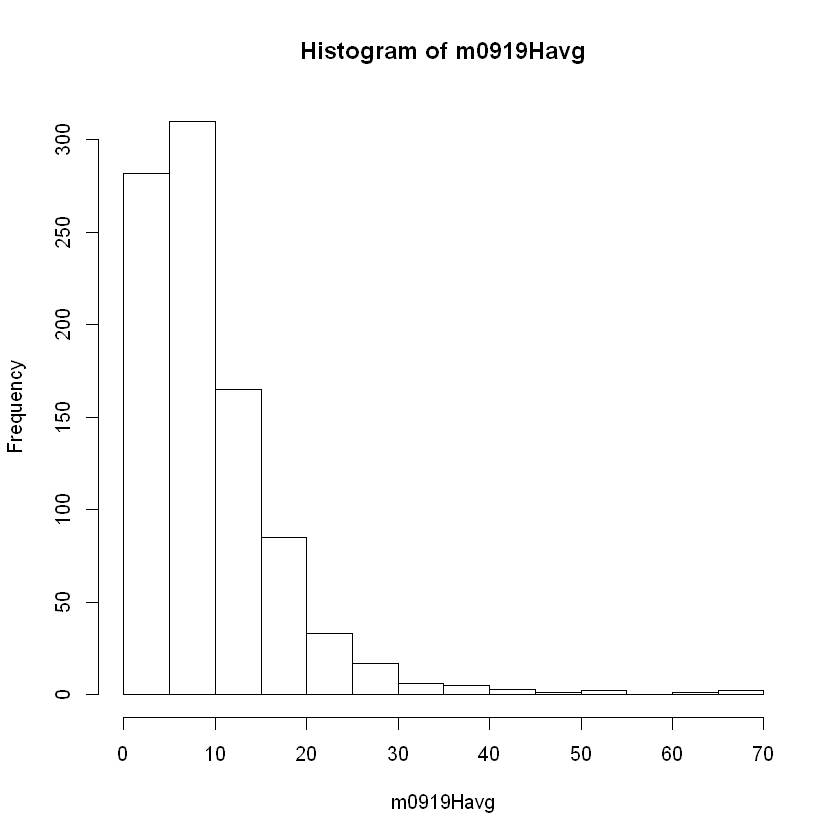

In [80]:
# 1hour average
m0919Havg <- apply(mtx0919avg, 1, mean)
hist(m0919Havg)

In [81]:
# cellid's above avg PRB 15% 
tmp_mtx <-m0919Havg[m0919Havg > 30]
cellid_heavy <- attr(tmp_mtx,"names")
cellid_heavy

[1] "1-17097-10" "1-17097-11" "1-17098-9"  "1-17101-0"  "1-17107-0" 
 [6] "1-17112-9"  "1-17124-10" "1-17128-0"  "1-20234-2"  "1-20238-11"
[11] "1-21622-9"  "1-24716-11" "1-24717-11" "1-25412-11" "1-26499-9" 
[16] "1-26503-1"  "1-26509-1"  "1-26513-1"  "1-26538-11" "1-26539-0"

1-17097-10 1-17097-11  1-17098-9  1-17101-0  1-17107-0  1-17112-9 1-17124-10 
        12          9          7          8         12         11         10 
 1-17128-0  1-20234-2 1-20238-11  1-21622-9 1-24716-11 1-24717-11 1-25412-11 
         8         12          9          4          3         12         12 
 1-26499-9  1-26503-1  1-26509-1  1-26513-1 1-26538-11  1-26539-0 
        12         10          7          9          9         10

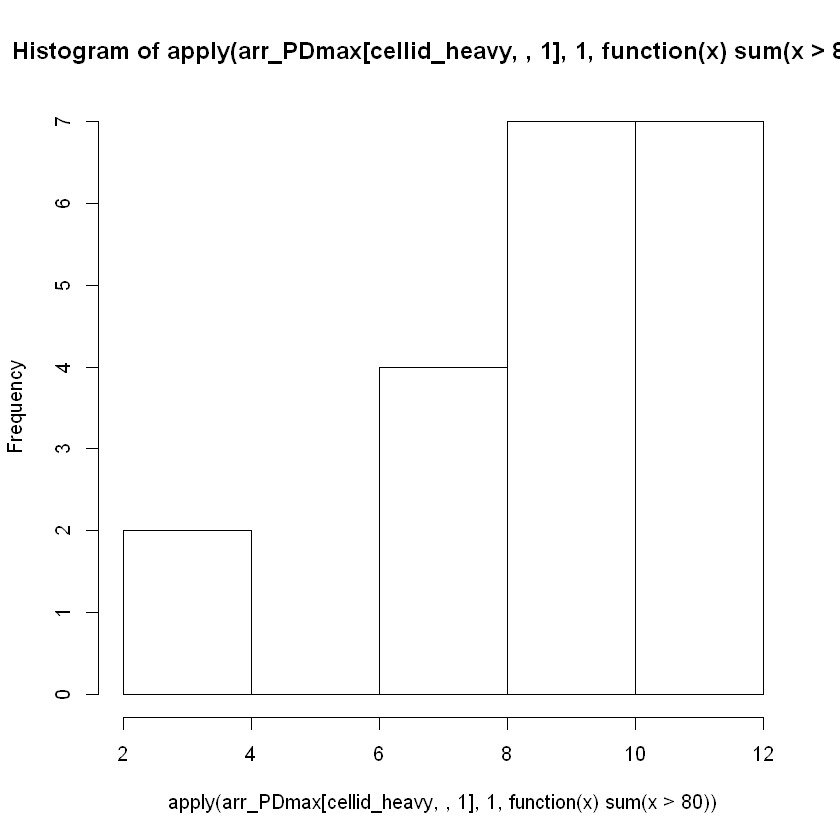

In [82]:
# counts of PRB max above 80 in the heavy avg cell  
apply(arr_PDmax[cellid_heavy,,1],1, function(x) sum(x > 80))
hist(apply(arr_PDmax[cellid_heavy,,1],1, function(x) sum(x > 80)))

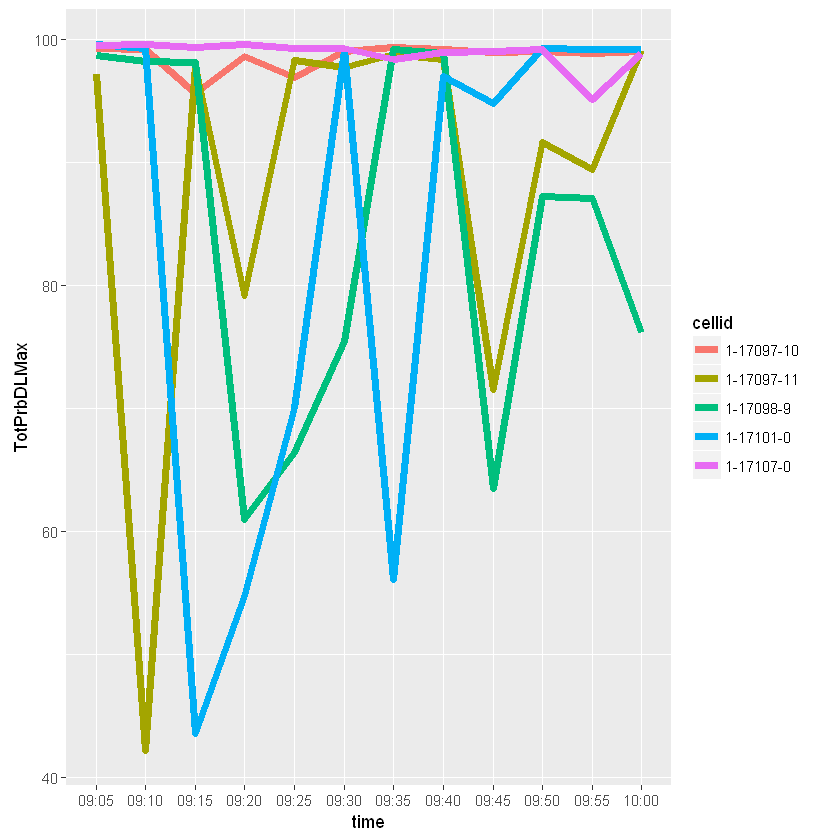

In [83]:
ggplot(p5M0919 %>% filter(cellid %in% cellid_heavy[1:5]),
       aes(time,TotPrbDLMax,color=cellid, group=cellid)) + geom_line(size=2) 

In [93]:
################ daily variance  #########

varList <-ls(pattern = "p5M\\d{4}")
var_list <- lapply(varList, function(x) eval(parse(text = x)) )
p5MTot <- do.call(rbind, var_list)



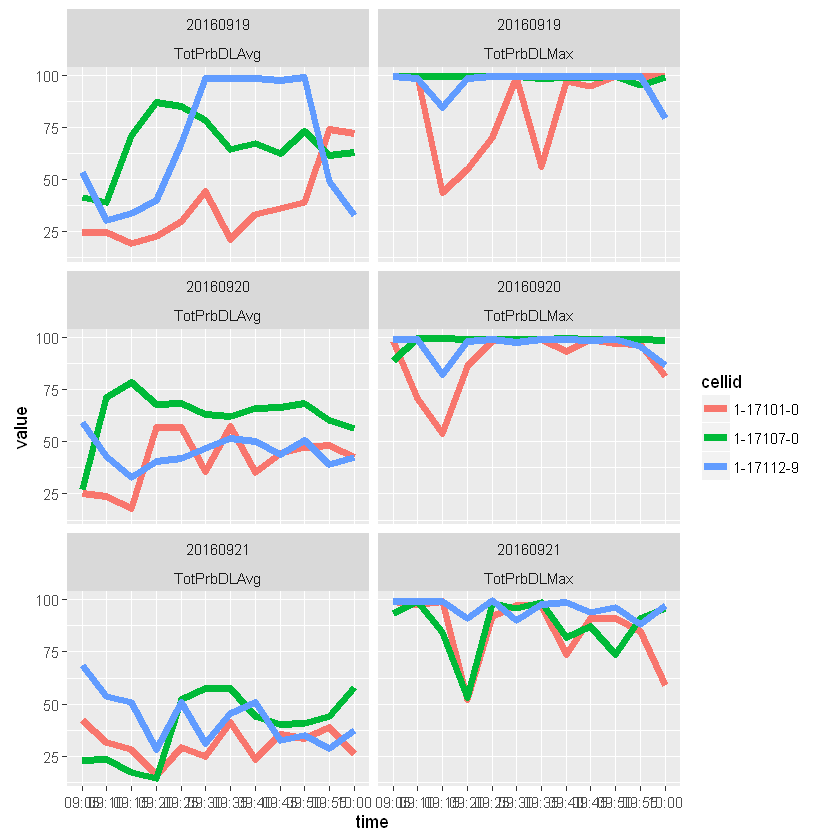

In [94]:

library(tidyr)
#library(devtools)

#head(p5MTot)

# colnames(p5MTot)[c(6,8)]  # [1] "TotPrbDLAvg" "TotPrbDLMax"

p5MTot.gr <- gather(p5MTot, "key", "value", c(6,8))

ggplot(p5MTot.gr %>% filter(cellid %in% cellid_heavy[4:6]),
       aes(time,value,color=cellid, group=cellid)) + geom_line(size=2) +
        facet_wrap(~date+key, ncol=2)

In [88]:
############### PRB hourly Trend 00:00 ~ 24:00 ########
varList <-ls(pattern = "prb1H\\d{4}$")
var_list <- lapply(varList, function(x) eval(parse(text = x)) )
prb1HTot <- do.call(rbind, var_list)


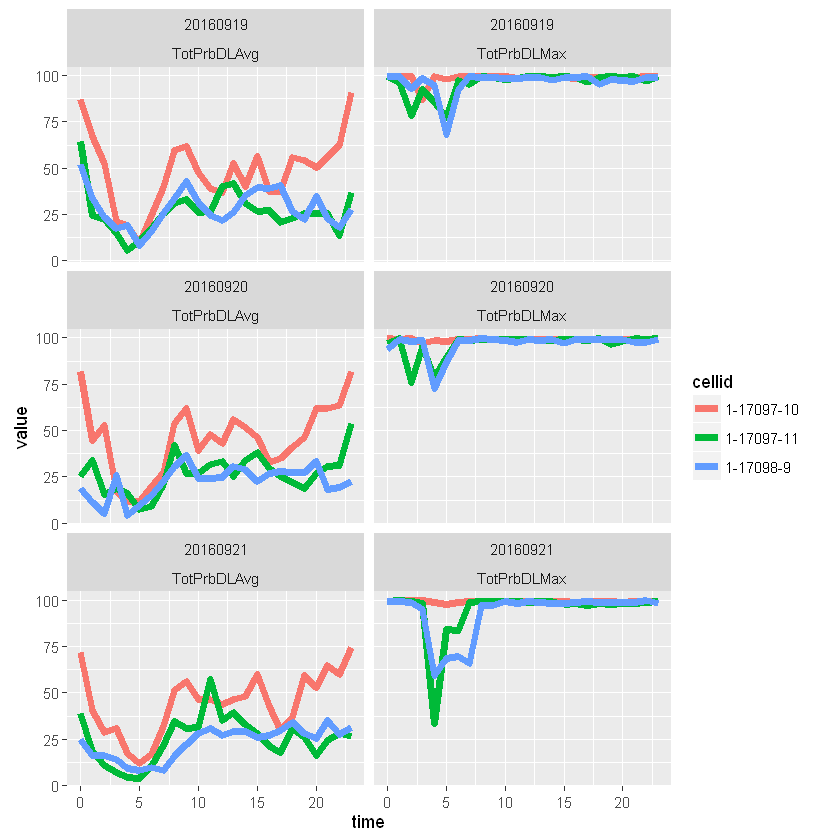

In [92]:
prb1HTot.gr <- gather(prb1HTot, "key", "value", c(6,8))

ggplot(prb1HTot.gr %>% filter(cellid %in% cellid_heavy[1:3]),
       aes(time,value,color=cellid, group=cellid)) + geom_line(size=2) +
        facet_wrap(~date+key, ncol=2)

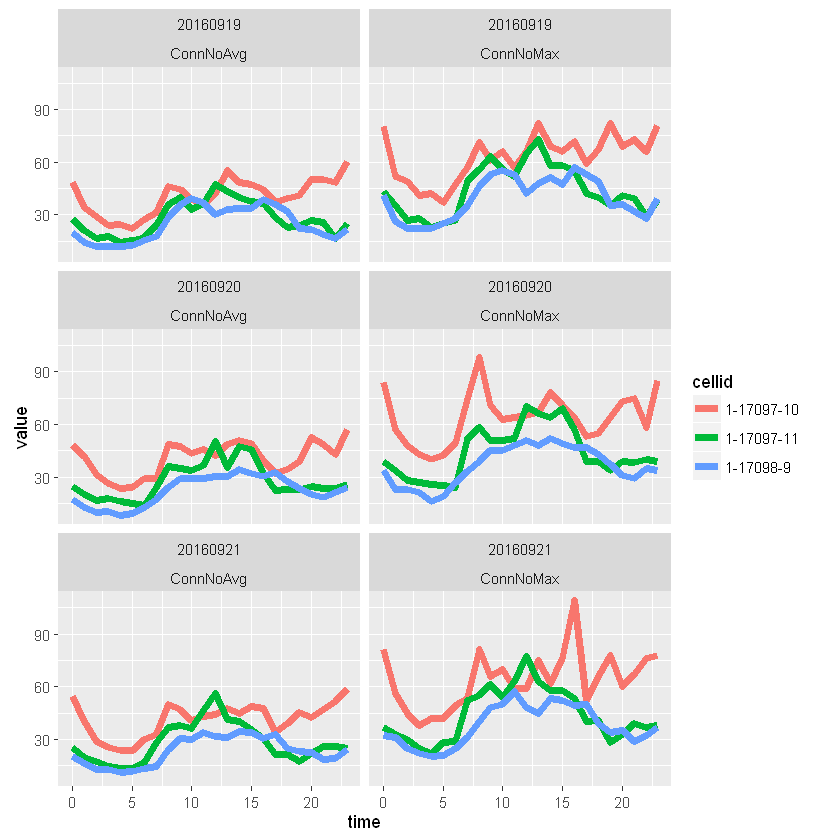

In [98]:
############### conn and others... ########
varList <-ls(pattern = "conn1H\\d{4}$")
var_list <- lapply(varList, function(x) eval(parse(text = x)) )
conn1HTot <- do.call(rbind, var_list)

conn1HTot.gr <- gather(conn1HTot, "key", "value", c(5,6))


ggplot(conn1HTot.gr %>% filter(cellid %in% cellid_heavy[1:3]),
       aes(time,value,color=cellid, group=cellid)) + geom_line(size=2) +
        facet_wrap(~date+key, ncol=2)